In [72]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [15]:
#packages
import sys
import ee
import math
import csv
import time
import glob
from random import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress

In [1]:
#csv with the addresses of the polling places
import pandas as pd
df=pd.read_csv('/content/turnout_NC_nov3_2020_pres.csv', encoding_errors='replace')
df.head()

countyXprecinct county_name precinct_name.x  \
0       ALAMANCE ALBRIGHT    ALAMANCE        ALBRIGHT   
1        ALAMANCE BOONE 5    ALAMANCE         BOONE 5   
2  ALAMANCE BURLINGTON 10    ALAMANCE   BURLINGTON 10   
3   ALAMANCE BURLINGTON 4    ALAMANCE    BURLINGTON 4   
4   ALAMANCE BURLINGTON 5    ALAMANCE    BURLINGTON 5   

               polling_place_name              street_name  house_num  \
0   SOUTHERN ALAMANCE HIGH SCHOOL  SOUTHERN HIGH SCHOOL RD        631   
1          ELON ELEMENTARY SCHOOL                WALKER RD        720   
2  ST PAUL'S UNITED METHODIST CHU                TRAIL TWO        609   
3     HILLCREST ELEMENTARY SCHOOL                 DAVIS ST       1714   
4       GROVE PARK BAPTIST CHURCH                TRAIL ONE        108   

         city state    zip  vote_ct_agg  voters_registered   turnout  
0      GRAHAM    NC  27253         2617               3128  0.836637  
1        ELON    NC  27244         3335               4586  0.727213  
2  BURLINGTON    NC  27215         1425               2006  0.710369  
3  BURLINGTON    NC  27215         1454               1821  0.798462  
4  BURLINGTON    NC  27215         1643               2030  0.809360

In [6]:
df.shape

(2546, 12)

#### GEOSPATIAL DOWNLOAD:

In [2]:
#downloading data based on street_name,house_number,city,state,zip from openstreetmap
import requests
import urllib.parse
dat=[]
for i in range(df.shape[0]):  
  address = str(df['house_num'][i])+","+str(df['street_name'][i])+","+str(df['city'][i])+","+str(df['state'][i])+" "+str(df['zip'][i])
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

  response = requests.get(url).json()
  print(response)
  dat.append(response)

[]
[{'place_id': 289898080, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 16398996, 'boundingbox': ['36.11767161559', '36.11777161559', '-79.495784853523', '-79.495684853523'], 'lat': '36.11772161558995', 'lon': '-79.49573485352256', 'display_name': '720, Walker Road, Elon, Alamance County, North Carolina, 27244, United States', 'class': 'place', 'type': 'house', 'importance': -0.63}]
[{'place_id': 289911557, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 16391901, 'boundingbox': ['36.070174641205', '36.070274641205', '-79.46192443128', '-79.46182443128'], 'lat': '36.070224641204945', 'lon': '-79.46187443128025', 'display_name': '609, Trail Two, Dogwood Acres, Burlington, Alamance County, North Carolina, 27215, United States', 'class': 'place', 'type': 'house', 'importance': -0.5299999999999999}]
[{'place_id': 289906905, 'licence': 'Data © OpenStreetMap

In [4]:
#total number of data obtained
coun=0;
for i in dat:
  if len(i)!=0:
    coun+=1;
coun

1744

In [5]:
#writing it down in a text file
with open('data_house_num_level.txt','w') as file:
  for i in dat:
    if len(i)!=0:
      file.write(i[0]['lat'])
      file.write(',')
      file.write(i[0]['lon'])
      file.write(',')
      file.write(i[0]['display_name'])
      file.write("\n")
    else:
      file.write('NA')
      file.write("\n")

In [7]:
#downloading street level data
dat_street_level=[]
for i in range(df.shape[0]):  
  address = str(df['street_name'][i])+","+str(df['city'][i])+","+str(df['state'][i])+" "+str(df['zip'][i])
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

  response = requests.get(url).json()
  print(response)
  dat_street_level.append(response)

[]
[{'place_id': 102815688, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 16398996, 'boundingbox': ['36.1125595', '36.1234796', '-79.4970357', '-79.4951411'], 'lat': '36.1180674', 'lon': '-79.4958767', 'display_name': 'Walker Road, Elon, Alamance County, North Carolina, 27244, United States', 'class': 'highway', 'type': 'residential', 'importance': 0.51}]
[{'place_id': 102808486, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 16391901, 'boundingbox': ['36.066407', '36.0812754', '-79.4628559', '-79.457711'], 'lat': '36.074395', 'lon': '-79.462072', 'display_name': 'Trail Two, Dogwood Acres, Burlington, Alamance County, North Carolina, 27215, United States', 'class': 'highway', 'type': 'tertiary', 'importance': 0.61}, {'place_id': 255953894, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 7

In [8]:
coun=0;
for i in dat_street_level:
  if len(i)!=0:
    coun+=1;
coun

1778

In [10]:
with open('data_street_name_level.txt','w') as file:
  for i in dat_street_level:
    if len(i)!=0:
      file.write(i[0]['lat'])
      file.write(',')
      file.write(i[0]['lon'])
      file.write(',')
      file.write(i[0]['display_name'])
      file.write("\n")
    else:
      file.write('NA')
      file.write("\n")

In [12]:
dat_ps_level=[]
for i in range(df.shape[0]):  
  address = str(df['city'][i])+","+str(df['state'][i])+" "+str(df['zip'][i])
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

  response = requests.get(url).json()
  print(response)
  dat_ps_level.append(response)

[{'place_id': 282306812, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 179966, 'boundingbox': ['36.016422', '36.0887081', '-79.432804', '-79.33954'], 'lat': '36.0690258', 'lon': '-79.4005756', 'display_name': 'Graham, Alamance County, North Carolina, United States', 'class': 'boundary', 'type': 'administrative', 'importance': 0.6729478114429206, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}]
[{'place_id': 282436334, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 179968, 'boundingbox': ['36.0815113', '36.154828', '-79.5351366', '-79.4748243'], 'lat': '36.1013924', 'lon': '-79.50749148641479', 'display_name': 'Elon, Alamance County, North Carolina, United States', 'class': 'boundary', 'type': 'administrative', 'importance': 0.6034940930419462, 'icon': 'https://nominatim.openstreetmap.org/ui/mapic

In [13]:
#total number of data obtained
coun=0;
for i in dat_ps_level:
  if len(i)!=0:
    coun+=1;
coun

2545

In [62]:
with open('data_zip_level.txt','w') as file:
  for i in dat_ps_level:
    if len(i)!=0:
      file.write(i[0]['lat'])
      file.write(',')
      file.write(i[0]['lon'])
      file.write(',')
      file.write(i[0]['display_name'])
      file.write("\n")
    else:
      file.write('NA')
      file.write("\n")

#### SATELLITE IMAGE DOWNLOAD:

In [16]:
ee.Authenticate() #google earth engine

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=VGE7DX5wOiShgdIXK-uojoQjmEO9Js12v1SKnU-Eezs&tc=Ir-yNDafMOpAoJ-gPjpsiAwlcoJ2tUkUZG_zx4qs1FM&cc=yc5vWB2H7_lE-sUQs1hFaVjL-tgXc5M6Iv86MWc6TAg

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AdQt8qjLSeS8K7Rcr-T1KBk7RC2Wz1yU9pG4KoXsLUjPSfVnizoF_w220NE

Successfully saved authorization token.


In [17]:
ee.Initialize()

In [18]:
#get the bounding box data of US
def get_country_bounding_box(country):
    # All the country borders
    # https://developers.google.com/earth-engine/datasets/catalog/USDOS_LSIB_SIMPLE_2017
    country_borders = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    # Get the border of the country, i.e. the shape of the country
    border = country_borders.filter(ee.Filter.eq("country_co", country))
    # Get the bounding box around the border of the country (a rectangle)
    return border.geometry().bounds()

In [19]:
country_borders = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    # Get the border of the country, i.e. the shape of the country
border = country_borders.filter(ee.Filter.eq("country_co", 'US'))

In [21]:
#get sentinel images using the following function
def get_sentinel_image(bounds):
    collection = (
        ee.ImageCollection("COPERNICUS/S2")
            .filterDate('2020-01-01', '2020-12-31')
            .filterBounds(bounds)
            .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 5)
    )
    final_image = collection.median().select('B4', 'B3', 'B2')
    # try composite method https://developers.google.com/earth-engine/guides/landsat
    # final_image = ee.Algorithms.Landsat.simpleComposite(collection)
    return final_image

In [22]:
#getting image boundary box for each site
def square_around_circle_around_coord(lat, long, radius=1500):
    #     could be replaced with a .point.buffer construction
    ''' Function to calculate the radius around the polling station'''
    dy = radius
    dx = radius
    # Radius Earth in metres approx
    r_earth = 6378000
    # calc lat
    new_latitude_max  = lat  + (dy / r_earth) * (180 / math.pi)
    new_latitude_min  = lat  - (dy / r_earth) * (180 / math.pi)
    # calc long
    new_longitude_max = long + (dx / r_earth) * (180 / math.pi) / math.cos(lat * math.pi/180)
    new_longitude_min = long - (dx / r_earth) * (180 / math.pi) / math.cos(lat * math.pi/180)
    # return order matching input for ee.Geometry.Rectangle:  xMin, yMin, xMax, yMax.
    return(new_longitude_min, new_latitude_min, new_longitude_max, new_latitude_max)

In [23]:
def save_image(image, satellite_name, ps_id, region):
    filename = f"{ps_id}"
    task = ee.batch.Export.image.toDrive(
        image=image,
        region=region.getInfo()['coordinates'],
        description=filename,
        folder="NorthCarolina_Sentinel2_PS_Data_scale30",
        scale=30
        # folder="Dev_GEE",
        # dimensions=500
    )
    task.start()

In [63]:
##Reading zip level data to get satellite images according to the data
import os  
# Using readlines()
file1 = open('/content/data_zip_level.txt', 'r')
Lines = file1.readlines()
dat=[]
count = 0
# Strips the newline character
for line in Lines:
    count += 1
    l=[0,0]
    if line!='NA\n':
        print("Line{}: {}".format(count, [float(i) for i in line.strip().split(',')[:2]]))
        dat.append([float(i) for i in line.strip().split(',')[:2]])
    else:
        print(("Line{}: {}".format(count, l)))
        dat.append(l)

Line1: [36.0690258, -79.4005756]
Line2: [36.1013924, -79.50749148641479]
Line3: [36.068716699999996, -79.45717434400953]
Line4: [36.068716699999996, -79.45717434400953]
Line5: [36.068716699999996, -79.45717434400953]
Line6: [36.068716699999996, -79.45717434400953]
Line7: [36.068716699999996, -79.45717434400953]
Line8: [36.068716699999996, -79.45717434400953]
Line9: [36.068716699999996, -79.45717434400953]
Line10: [36.068716699999996, -79.45717434400953]
Line11: [36.068716699999996, -79.45717434400953]
Line12: [36.068716699999996, -79.45717434400953]
Line13: [36.0690258, -79.4005756]
Line14: [36.068716699999996, -79.45717434400953]
Line15: [36.068716699999996, -79.45717434400953]
Line16: [36.068716699999996, -79.45717434400953]
Line17: [36.091526, -79.3641862]
Line18: [36.0966835, -79.27085471736478]
Line19: [36.0966835, -79.27085471736478]
Line20: [36.1013924, -79.50749148641479]
Line21: [36.1013924, -79.50749148641479]
Line22: [36.068716699999996, -79.45717434400953]
Line23: [36.06871

In [64]:
#storing the latitude and longitude
latlon=pd.DataFrame()
latlon['long']=[i[1]for i in dat]
latlon['lat']=[i[0]for i in dat]
latlon.head()

long        lat
0 -79.400576  36.069026
1 -79.507491  36.101392
2 -79.457174  36.068717
3 -79.457174  36.068717
4 -79.457174  36.068717

In [65]:
latlon['polling_place_name']=df['polling_place_name']

In [33]:
latlon['polling_place_name']

0        SOUTHERN ALAMANCE HIGH SCHOOL
1               ELON ELEMENTARY SCHOOL
2       ST PAUL'S UNITED METHODIST CHU
3          HILLCREST ELEMENTARY SCHOOL
4            GROVE PARK BAPTIST CHURCH
                     ...              
2541       CLEARMONT ELEMENTARY SCHOOL
2542               PENSACOLA FIRE DEPT
2543          CANE RIVER MIDDLE SCHOOL
2544              RAMSEYTOWN FIRE DEPT
2545       SOUTH TOE ELEMENTARY SCHOOL
Name: polling_place_name, Length: 2546, dtype: object

In [66]:
latlon.to_csv('polling_stations_long_lat_nc2020.csv')

In [67]:
#aligning the data according to the polling_station_name 
def polling_station_reader(filename):
    dat = []
    with open(ps_data_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader, None)
        for row in reader:
            dat.append(row)
    # build masks to filter for missings
    mask_NAN_all = [[one_obs=='0.0' for one_obs in one_line] for one_line in dat]
    mask_no_NAN_one_line = [not any(one_line) for one_line in mask_NAN_all]
    # select
    dat = list(compress(dat, mask_no_NAN_one_line))
    # OJO: the person who set up the spreadsheet but long before lat.
    # Convention is the other way round
    long = []
    lat = []
    ps_id = []
    for i in range(len(dat)):
        long.append(float(dat[i][1]))
        lat.append(float(dat[i][2]))
        ps_id.append(int(dat[i][0]))
    # reduce the data to the unique polling station IDs
    ps_id_unique, ps_id_index = np.unique(ps_id, return_index=True)
    lat = list(np.array(lat)[ps_id_index])
    long = list(np.array(long)[ps_id_index])
    ps_id = list(np.array(ps_id)[ps_id_index])
    # TODO. This is the location where we patch in case the
    # download process was interrupted
    # lat = lat[foo:]
    # long = long[foo:]
    # ps_id = ps_id[foo:]
    return lat, long, ps_id

In [68]:
ps_data_path = "polling_stations_long_lat_nc2020.csv"
country = "US"

In [69]:
lat,long,ps_id = polling_station_reader(ps_data_path)
print(len(ps_id))#for sanity check

2545


In [70]:
#helper function to use the above functions and download data
def download_data(ps_data_path, country):
    lat,long,ps_id = polling_station_reader(ps_data_path)
    lat=[float(i) for i in lat]
    # loop for each element in the locations
    t1 = time.time()
    for i in range(len(ps_id)):
        print('Working on PS', ps_id[i],
                'which is #', i+1, 'on the list. Overall',
                round((i+1)*100/len(ps_id), 2), '% done.')
        aoi=ee.Geometry.Rectangle(square_around_circle_around_coord(lat[i], long[i]))
        save_image(get_sentinel_image(get_country_bounding_box(country)), "SENTINEL", ps_id[i], aoi)
        # each turn make pause. Take at least 2 seconds to prevent HttpError 400
        # "A different Operation was already started with the given request_id."
        time.sleep(2+random())
        # Make a pause on average every 30 iteration
        if (random() < .03):
            print("zzzzzz... taking a 1 mins nap now")
            time.sleep(30+(random()*30))
    t2 = time.time()
    overall_time = t2-t1
    print("It takes on average", round(overall_time/len(ps_id), 2), 'seconds per image (including the pause)')

In [71]:
download_data(ps_data_path, country)

Working on PS 0 which is # 1 on the list. Overall 0.04 % done.
Working on PS 1 which is # 2 on the list. Overall 0.08 % done.
Working on PS 2 which is # 3 on the list. Overall 0.12 % done.
Working on PS 3 which is # 4 on the list. Overall 0.16 % done.
Working on PS 4 which is # 5 on the list. Overall 0.2 % done.
Working on PS 5 which is # 6 on the list. Overall 0.24 % done.
Working on PS 6 which is # 7 on the list. Overall 0.28 % done.
Working on PS 7 which is # 8 on the list. Overall 0.31 % done.
Working on PS 8 which is # 9 on the list. Overall 0.35 % done.
Working on PS 9 which is # 10 on the list. Overall 0.39 % done.
Working on PS 10 which is # 11 on the list. Overall 0.43 % done.
Working on PS 11 which is # 12 on the list. Overall 0.47 % done.
Working on PS 12 which is # 13 on the list. Overall 0.51 % done.
Working on PS 13 which is # 14 on the list. Overall 0.55 % done.
Working on PS 14 which is # 15 on the list. Overall 0.59 % done.
Working on PS 15 which is # 16 on the list. O

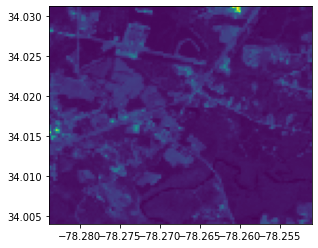

In [75]:
import rasterio
from rasterio.plot import show
fp = r'/content/drive/MyDrive/NorthCarolina_Sentinel2_PS_Data_scale30/168.tif'
img = rasterio.open(fp)
show(img)

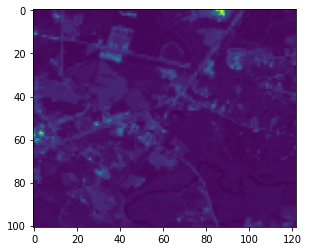

In [76]:
img = rasterio.open(fp) 
# mention band no. in read() method starting from 1 not 0
show(img.read(3))